##MNIST DATSET

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(1.0))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = batch_size, shuffle=False)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num=10):
    super(AlexNet, self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=5, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32,64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 96, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(96, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(32*12*12, 2048),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, num)
    )

  def forward(self, x):
    x=self.feature(x)
    x=x.view(-1,32*12*12)
    x=self.classifier(x)
    return x

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
  model.to(device)
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
  model.to(device)
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
model = AlexNet()
print(model)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train(data_loader = train_loader,
        model = model,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device,
        train_losses = train_losses,
        train_accuracy = train_accuracy
        )
  test(data_loader = test_loader,
       model = model,
       loss_fn = loss_fn,
       accuracy_fn = accuracy_fn,
       device = device,
       test_losses = test_losses,
       test_accuracy = test_accuracy
       )

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU(in

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 2.30142 | Train accuracy: 11.12%


 10%|█         | 1/10 [00:23<03:31, 23.50s/it]

Test loss: 2.30041 | Test accuracy: 11.35%

Epoch: 1
-------
Train loss: 2.29896 | Train accuracy: 11.24%


 20%|██        | 2/10 [00:46<03:07, 23.38s/it]

Test loss: 2.28821 | Test accuracy: 11.60%

Epoch: 2
-------
Train loss: 0.89997 | Train accuracy: 69.93%


 30%|███       | 3/10 [01:10<02:43, 23.32s/it]

Test loss: 0.15048 | Test accuracy: 95.32%

Epoch: 3
-------
Train loss: 0.15701 | Train accuracy: 95.10%


 40%|████      | 4/10 [01:33<02:19, 23.31s/it]

Test loss: 0.07507 | Test accuracy: 97.49%

Epoch: 4
-------
Train loss: 0.10161 | Train accuracy: 96.83%


 50%|█████     | 5/10 [01:57<01:57, 23.48s/it]

Test loss: 0.05381 | Test accuracy: 98.38%

Epoch: 5
-------
Train loss: 0.07892 | Train accuracy: 97.46%


 60%|██████    | 6/10 [02:20<01:33, 23.46s/it]

Test loss: 0.04370 | Test accuracy: 98.55%

Epoch: 6
-------
Train loss: 0.06850 | Train accuracy: 97.87%


 70%|███████   | 7/10 [02:43<01:10, 23.38s/it]

Test loss: 0.03859 | Test accuracy: 98.75%

Epoch: 7
-------
Train loss: 0.05831 | Train accuracy: 98.20%


 80%|████████  | 8/10 [03:06<00:46, 23.33s/it]

Test loss: 0.03710 | Test accuracy: 98.80%

Epoch: 8
-------
Train loss: 0.05397 | Train accuracy: 98.30%


 90%|█████████ | 9/10 [03:30<00:23, 23.35s/it]

Test loss: 0.03203 | Test accuracy: 98.95%

Epoch: 9
-------
Train loss: 0.04777 | Train accuracy: 98.45%


100%|██████████| 10/10 [03:53<00:00, 23.39s/it]

Test loss: 0.02856 | Test accuracy: 98.95%



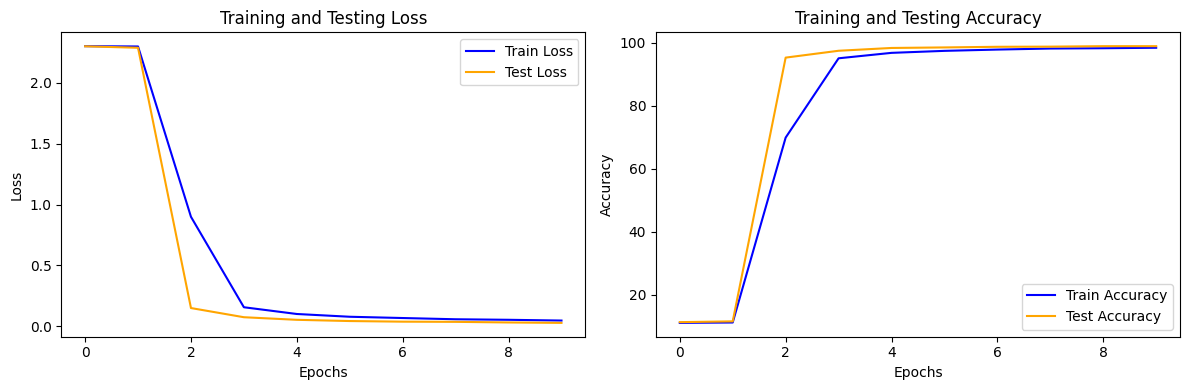

In [ ]:
def plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(test_accuracy, label='Test Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)


##SIFAR DATSET

In [ ]:
trans_1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))])
train_set_1 = dset.CIFAR10(root='./data', train=True, transform=trans, download=True)
test_set_1 = dset.CIFAR10(root='./data', train=False, transform=trans)
batch_size = 32

100%|██████████| 170498071/170498071 [00:02<00:00, 80321485.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set_1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set_1, batch_size = batch_size, shuffle=False)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num=10):
    super(AlexNet, self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(256, 512, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(512, 256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 4 * 4, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num)
    )

  def forward(self, x):
    x=self.feature(x)
    x=x.view(-1,256*4*4)
    x=self.classifier(x)
    return x

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
  model.to(device)
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
  model.to(device)
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y_true=y, y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
model = AlexNet()
print(model)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train(data_loader = train_loader,
        model = model,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device,
        train_losses = train_losses,
        train_accuracy = train_accuracy
        )
  test(data_loader = test_loader,
       model = model,
       loss_fn = loss_fn,
       accuracy_fn = accuracy_fn,
       device = device,
       test_losses = test_losses,
       test_accuracy = test_accuracy
       )

AlexNet(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inp

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 2.30260 | Train accuracy: 10.26%


 10%|█         | 1/10 [00:31<04:47, 31.91s/it]

Test loss: 2.30228 | Test accuracy: 10.01%

Epoch: 1
-------
Train loss: 2.30215 | Train accuracy: 10.58%


 20%|██        | 2/10 [01:02<04:09, 31.24s/it]

Test loss: 2.30127 | Test accuracy: 10.01%

Epoch: 2
-------
Train loss: 2.29873 | Train accuracy: 13.59%


 30%|███       | 3/10 [01:33<03:38, 31.20s/it]

Test loss: 2.28383 | Test accuracy: 19.70%

Epoch: 3
-------
Train loss: 2.08798 | Train accuracy: 22.77%


 40%|████      | 4/10 [02:04<03:06, 31.09s/it]

Test loss: 1.98084 | Test accuracy: 27.81%

Epoch: 4
-------
Train loss: 1.80162 | Train accuracy: 32.38%


 50%|█████     | 5/10 [02:36<02:35, 31.15s/it]

Test loss: 1.62421 | Test accuracy: 39.24%

Epoch: 5
-------
Train loss: 1.63252 | Train accuracy: 39.12%


 60%|██████    | 6/10 [03:07<02:05, 31.32s/it]

Test loss: 1.59863 | Test accuracy: 41.32%

Epoch: 6
-------
Train loss: 1.52857 | Train accuracy: 43.36%


 70%|███████   | 7/10 [03:38<01:33, 31.18s/it]

Test loss: 1.47054 | Test accuracy: 45.40%

Epoch: 7
-------
Train loss: 1.43797 | Train accuracy: 46.54%


 80%|████████  | 8/10 [04:09<01:02, 31.14s/it]

Test loss: 1.59684 | Test accuracy: 42.60%

Epoch: 8
-------
Train loss: 1.35385 | Train accuracy: 50.07%


 90%|█████████ | 9/10 [04:40<00:31, 31.20s/it]

Test loss: 1.36939 | Test accuracy: 50.57%

Epoch: 9
-------
Train loss: 1.28128 | Train accuracy: 53.24%


100%|██████████| 10/10 [05:11<00:00, 31.17s/it]

Test loss: 1.21254 | Test accuracy: 55.53%



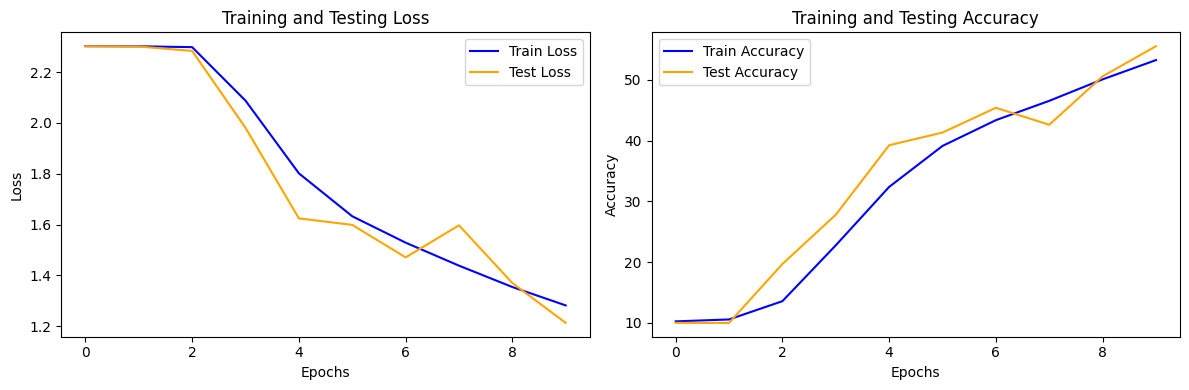

In [ ]:
plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)